<a href="https://colab.research.google.com/github/denisangelo/Federated_Learning/blob/main/ExemploCryptenRegressaoLogistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [388]:
#Importa Pytorch,crypten
!pip install crypten
!pip install torch
!pip install torchvision
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [389]:
#Importa as bibliotecas necessárias
import matplotlib.pyplot as plt
import numpy as np
import crypten
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

In [390]:
crypten.init()
torch.set_num_threads(1)

/usr/local/lib/python3.10/dist-packages/crypten/__init__.py:64: RuntimeWarning: CrypTen is already initialized.
  warnings.warn("CrypTen is already initialized.", RuntimeWarning)


In [391]:
#Carrega os dados CIFAR10

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#transform = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor(),])
trainset = CIFAR10(root="./data", train=True,download=True, transform=transform)
testset = CIFAR10(root="./data", train=False, download=True, transform=transform)
#labels

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Esta imagem é um: car


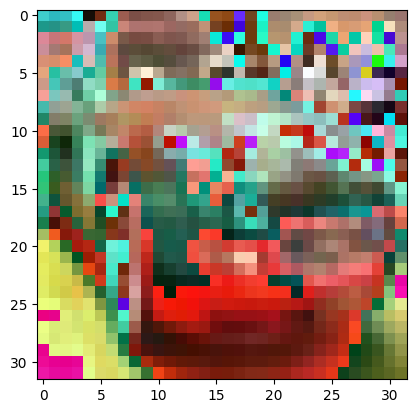

In [392]:
example = 5

image, label = trainset[example]

print("Esta imagem é um: " + classes[(trainset[example])[1]])
img = next(iter(trainset))[0][0]
plt.imshow(transforms.ToPILImage()(image))



In [393]:
print("O label da imagem é: ",trainset[0][1])

O label da imagem é:  6


In [394]:
#Pré processamento entre tensores
def take_samples(trainset, n_samples=1000):
  #Retorna images e labels em conjunto de amostras
  images,labels =[],[]
  for i,trainset in enumerate(trainset):
    if i==n_samples:
      break
    image, label = trainset
    images.append(image)
    label_one_hot = torch.nn.functional.one_hot(torch.tensor(label),10)
    labels.append(label_one_hot)

  images = torch.cat(images)
  labels = torch.stack(labels)
  return images,labels

In [395]:
images,labels = take_samples(trainset, n_samples=100)

In [396]:
print(images.shape)
print(labels.shape)

torch.Size([300, 32, 32])
torch.Size([100, 10])


In [397]:
images_enc = crypten.cryptensor(images)
labels_enc = crypten.cryptensor(labels)

In [398]:
images_enc[0]

MPCTensor(
	_tensor=tensor([[-35209, -43433, -39835,  ...,  15677,  12593,  10537],
        [-57311, -65536, -56283,  ...,  -2313,  -4369,  -2827],
        [-52685, -57311, -40349,  ...,  -4883,  -3855,  -9509],
        ...,
        [ 41377,  37779,  36237,  ...,  16705, -36751, -38293],
        [ 26985,  23387,  30069,  ...,  29041, -15677, -22873],
        [ 25443,  20817,  26471,  ...,  45489,  12079,  -2313]])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)

In [399]:
#Conjunto de imagens de teste
images_test,labels_test = take_samples(testset, n_samples=20)
images_test_enc = crypten.cryptensor(images_test)
labels_test_enc = crypten.cryptensor(labels_test)

In [404]:
#Modelo de regressão Logística
class LogisticRegression(crypten.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = crypten.nn.Linear(3*32*32,10)
  def forward(self,x):
    x=x.reshape(-1,3072)
    out =self.linear(x)
    return out

In [405]:
model = LogisticRegression().encrypt()

In [406]:
model(images_enc)

MPCTensor(
	_tensor=tensor([[    11,  -1287,  16313,    -30, -18307, -15076,   4487,   1341,  25021,
          -6962],
        [-24880,  24597,  -9799,   5745,  -2867, -11603,  22470,  16806, -18135,
           1955],
        [-21303,   6529,  -1886,  22512, -28178,  17463,  -7747,  -9842, -28717,
          14335],
        [ 18972,  -2024,  22963, -21635, -11044,  -2313,  12501, -24063,  33396,
          -1787],
        [ -1083,  10100,   8974,   7455,  -2375,  17772,  35953,  -3298, -16569,
           2544],
        [  8551, -13071,  43039, -18935, -38396,  -1350,   9082, -13612,  22034,
          -7380],
        [ -3349, -11007,   3198, -15749, -32449, -15708, -11479, -34112,  12795,
           3633],
        [  -307,  -9118,  -3769, -16378, -19660,  -3480,  -8047, -11970,   3327,
          -5625],
        [-22819,  -6760, -46326,   7548,  16717,  14529, -11139,   4722,  -8099,
         -14521],
        [ -2684,  11639,  23074, -19132,  -7250,  40916,   2803, -53642,  12602,
        

In [407]:
#Modelo de Treinamento em imagens criptografadas
def train_model(model, X, y, epochs=10, learning_rate=0.05):
    criterion = crypten.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        print(f"epoch {epoch} loss: {loss.get_plain_text()}")
        loss.backward()
        model.update_parameters(learning_rate)
    return model

In [408]:
model = train_model(model, images_enc, labels_enc)

epoch 0 loss: 2.399688720703125
epoch 1 loss: 1.9897918701171875
epoch 2 loss: 1.7850799560546875
epoch 3 loss: 1.6275177001953125
epoch 4 loss: 1.497222900390625
epoch 5 loss: 1.3869781494140625
epoch 6 loss: 1.29229736328125
epoch 7 loss: 1.20965576171875
epoch 8 loss: 1.136962890625
epoch 9 loss: 1.0726470947265625


In [409]:
#Acurácia do Modelo
def avg_test_accuracy(model, X, y):
    output = model(X).get_plain_text().softmax(0)
    predicted = output.argmax(1)
    labels = y.get_plain_text().argmax(1)
    correct = (predicted == labels).sum().float()
    return float(correct / y.shape[0])

In [410]:
avg_test_accuracy(model, images_enc, labels_enc)

0.8600000143051147

In [411]:
avg_test_accuracy(model, images_test_enc, labels_test_enc)

0.15000000596046448